In [1]:
from pathlib import Path
from asim.dataset.scene.arrow_scene import ArrowScene
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt

import numpy as np

from asim.common.geometry.base import Point2D
from asim.common.geometry.bounding_box.bounding_box import BoundingBoxSE2, BoundingBoxSE3
from asim.common.geometry.tranform_2d import translate_along_yaw
from asim.common.visualization.color.color import ELLIS_5
from asim.dataset.scene.abstract_scene import AbstractScene

from asim.common.visualization.matplotlib.map import add_default_map_on_ax
from asim.common.visualization.matplotlib.observation import add_box_detections_to_ax, add_ego_vehicle_to_ax, add_traffic_lights_to_ax

from asim.common.geometry.base import Point3D

from asim.common.visualization.color.default import BOX_DETECTION_CONFIG


<Axes: title={'center': 'Map: nuplan_us-ma-boston'}>

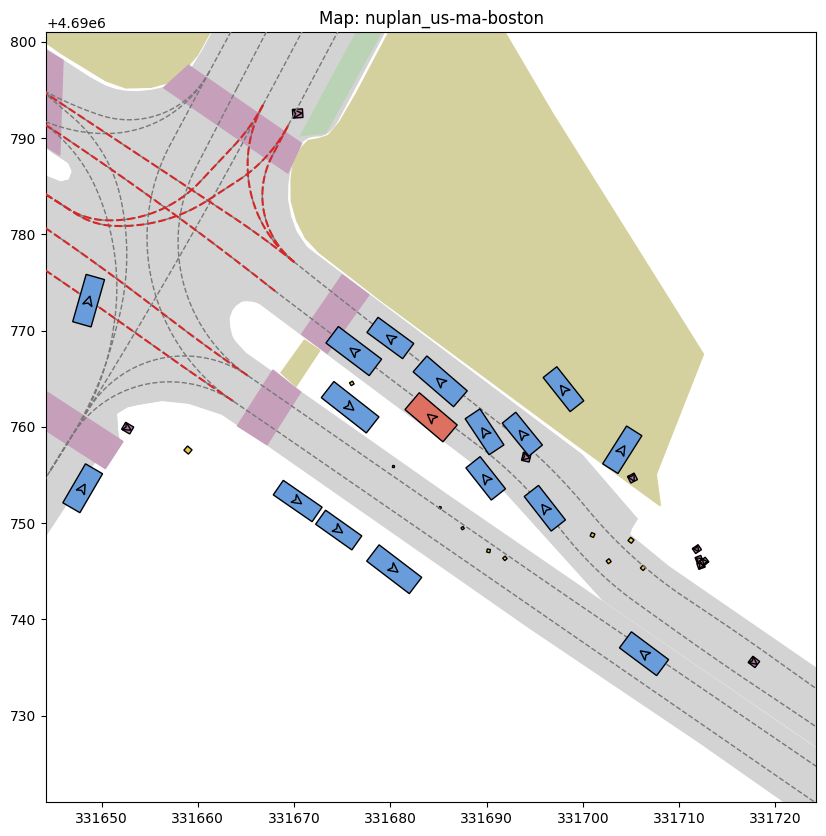

In [2]:



def plot_scene_at_iteration(scene: AbstractScene, iteration: int = 0, ax: Optional[plt.Axes] = None):

    radius = 50

    ego_vehicle_state = scene.get_ego_vehicle_state_at_iteration(iteration)
    box_detections = scene.get_box_detections_at_iteration(iteration)
    traffic_light_detections = scene.get_traffic_light_detections_at_iteration(iteration)
    map_api = scene.map_api

    point_2d = ego_vehicle_state.bounding_box.center.state_se2.point_2d

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    add_default_map_on_ax(ax, map_api, point_2d, radius=radius)
    add_traffic_lights_to_ax(ax, traffic_light_detections, map_api)

    add_box_detections_to_ax(ax, box_detections)
    add_ego_vehicle_to_ax(ax, ego_vehicle_state)

    buffer_radius = 0.8 * radius
    ax.set_xlim(point_2d.x - buffer_radius, point_2d.x + buffer_radius)
    ax.set_ylim(point_2d.y - buffer_radius, point_2d.y + buffer_radius)

    ax.set_aspect("equal", adjustable="box")

    return ax

# Looks like a cool scene
log_name = "2021.08.30.14.54.34_veh-40_00439_00835"
log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")
scene = ArrowScene(log_file)

# log_name = "2021.08.30.14.54.34_veh-40_00439_00835"
# log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")
scene = ArrowScene(log_file)

plot_scene_at_iteration(scene, iteration=100)

In [3]:
from asim.common.geometry.base import StateSE3
from asim.common.visualization.color.color import Color
from asim.common.visualization.color.config import PlotConfig
import trimesh
from scipy.spatial.transform import Rotation

def bounding_box_to_trimesh(bbox: BoundingBoxSE3, plot_config: PlotConfig) -> trimesh.Trimesh:
    """
    Convert a 3D bounding box to a trimesh object.

    Args:
        bbox: BoundingBoxSE3 object containing center pose and dimensions

    Returns:
        trimesh.Trimesh: A box mesh representing the bounding box
    """
    # Create a unit box centered at origin
    box_mesh = trimesh.creation.box(extents=[bbox.length, bbox.width, bbox.height])

    # Create rotation matrix from roll, pitch, yaw (intrinsic rotations)
    # Using 'xyz' convention: roll (x), pitch (y), yaw (z)
    rotation = Rotation.from_euler("xyz", [bbox.center.roll, bbox.center.pitch, bbox.center.yaw])
    rotation_matrix = rotation.as_matrix()

    # Create 4x4 transformation matrix
    transform_matrix = np.eye(4)
    transform_matrix[:3, :3] = rotation_matrix
    transform_matrix[:3, 3] = [bbox.center.x, bbox.center.y, bbox.center.z]

    # Apply transformation to the box
    box_mesh.apply_transform(transform_matrix)

    base_color = [r/255.0 for r in plot_config.fill_color.rgba]
    box_mesh.visual.face_colors = plot_config.fill_color.rgba



    pbr_material = trimesh.visual.material.PBRMaterial(
        baseColorFactor=base_color,         # Your desired color (RGBA, 0-1 range)
        metallicFactor=1.0,                 # 0.0 = non-metallic (more matte)
        roughnessFactor=0.9,                # 0.8 = quite rough (less shiny, 0=mirror, 1=completely rough)
        emissiveFactor=[0.0, 0.0, 0.0],    # No emission
        alphaCutoff=0.75,                    # Alpha threshold for transparency
        doubleSided=False                   # Single-sided material
    )
    box_mesh.visual.material = pbr_material

    return box_mesh


def bounding_box_to_trimesh_alternative(bbox: BoundingBoxSE3, plot_config: PlotConfig) -> trimesh.Trimesh:
    """
    Alternative implementation using trimesh's built-in transformation methods.

    Args:
        bbox: BoundingBoxSE3 object containing center pose and dimensions

    Returns:
        trimesh.Trimesh: A box mesh representing the bounding box
    """
    # Create a unit box centered at origin
    box_mesh = trimesh.creation.box(extents=[bbox.length, bbox.width, bbox.height])

    # Apply rotations in order: roll, pitch, yaw
    box_mesh = box_mesh.apply_transform(trimesh.transformations.rotation_matrix(bbox.center.roll, [1, 0, 0]))
    box_mesh = box_mesh.apply_transform(trimesh.transformations.rotation_matrix(bbox.center.pitch, [0, 1, 0]))
    box_mesh = box_mesh.apply_transform(trimesh.transformations.rotation_matrix(bbox.center.yaw, [0, 0, 1]))

    # Apply translation
    box_mesh = box_mesh.apply_translation([bbox.center.x, bbox.center.y, bbox.center.z])
    box_mesh.visual.face_colors = plot_config.fill_color.rgba

    return box_mesh





In [4]:
import viser


server = viser.ViserServer()

log_name = "2021.08.17.17.17.01_veh-45_02314_02798"
log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")

# log_name = "Town12_Rep0_longest6_route18_06_03_21_42_03"
# log_file = Path(f"/home/daniel/asim_workspace/data/carla/{log_name}.arrow")
# scene = ArrowScene(log_file)

# server.scene.add_light_hemisphere(name="ambient_light", sky_color=ELLIS_5[0].rgb, ground_color=ELLIS_5[1].rgb, intensity=1.0)
# server.scene.add_light_spot("test")

╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

In [5]:



from asim.common.visualization.color.default import EGO_VEHICLE_CONFIG


def translate_bounding_box_se3(bounding_box_se3: BoundingBoxSE3, point_3d: Point3D) -> BoundingBoxSE3:
    bounding_box_se3.center.x = bounding_box_se3.center.x - point_3d.x
    bounding_box_se3.center.y = bounding_box_se3.center.y - point_3d.y
    bounding_box_se3.center.z = bounding_box_se3.center.z - point_3d.z
    return bounding_box_se3


iteration = 100

import time

start_time = time.time()
ego_vehicle_state = scene.get_ego_vehicle_state_at_iteration(iteration)
box_detections = scene.get_box_detections_at_iteration(iteration)
# traffic_light_detections = scene.get_traffic_light_detections_at_iteration(iteration)
# map_api = scene.map_api

center = ego_vehicle_state.bounding_box.center.point_3d
first, second, third = 0, 0, 0
meshes = []

for box_detection in box_detections:

    bbox: BoundingBoxSE3 = box_detection.bounding_box
    bbox = translate_bounding_box_se3(bbox, center)

    plot_config = BOX_DETECTION_CONFIG[box_detection.metadata.detection_type]
    trimesh_box = bounding_box_to_trimesh(bbox, plot_config)
    meshes.append(trimesh_box)

combined = trimesh.util.concatenate(meshes)

# server.scene.add_mesh_trimesh(name=f"{box_detection.metadata.detection_type.serialize()}/{box_detection.metadata.track_token}", mesh=trimesh_box,)
server.scene.add_mesh_trimesh(name=f"vehicles", mesh=combined)
print(time.time() - start_time)


# print(f"Time taken for translation: {first:.4f}s")
# print(f"Time taken for trimesh conversion: {second:.4f}s")
# print(f"Time taken for adding to server: {third:.4f}s")
# ego_bbox = translate_bounding_box_se3(ego_vehicle_state.bounding_box, center)
# trimesh_box = bounding_box_to_trimesh_alternative(ego_bbox, EGO_VEHICLE_CONFIG)
# frame_handle = server.scene.add_frame("/frame")
# ego = server.scene.add_mesh_trimesh(name="/frame/ego", mesh=trimesh_box)

# server.scene.add_mesh_trimesh(name=f"vehicles", mesh=trimesh_box,)

0.012217283248901367


In [6]:
viser.__version__ 

'0.2.23'

In [7]:
import numpy as np
import trimesh
from shapely.geometry import LineString, Polygon

from asim.common.geometry.line.polylines import Polyline3D
from asim.common.visualization.color.default import MAP_SURFACE_CONFIG
from asim.dataset.maps.abstract_map_objects import AbstractLane, AbstractLaneGroup, AbstractSurfaceMapObject

import numpy as np
import numpy.typing as npt

from typing import List
from asim.dataset.maps.map_datatypes import MapSurfaceType


layers: List[MapSurfaceType] = [
    MapSurfaceType.LANE,
    MapSurfaceType.LANE_GROUP,
    MapSurfaceType.GENERIC_DRIVABLE,
    MapSurfaceType.CARPARK,
    MapSurfaceType.CROSSWALK,
    MapSurfaceType.INTERSECTION,
    MapSurfaceType.WALKWAY,
]


# def interpolate_polyline(polyline_3d: Polyline3D, num_samples: int = 20) -> npt.NDArray[np.float64]:
#     distances = np.linspace(0, polyline_3d.length, num=num_samples, endpoint=True, dtype=np.float64)
#     return polyline_3d.interpolate(distances)


# def create_lane_mesh_from_boundary_arrays(
#     left_boundary_array: npt.NDArray[np.float64],
#     right_boundary_array: npt.NDArray[np.float64],
# ) -> trimesh.Trimesh:

#     # Ensure both polylines have the same number of points
#     if left_boundary_array.shape[0] != right_boundary_array.shape[0]:
#         raise ValueError("Both polylines must have the same number of points")

#     n_points = left_boundary_array.shape[0]

#     # Combine vertices from both polylines
#     vertices = np.vstack([left_boundary_array, right_boundary_array])

#     # Create faces by connecting corresponding points on the two polylines
#     faces = []
#     for i in range(n_points - 1):
#         faces.append([i, i + n_points, i + 1])
#         faces.append([i + 1, i + n_points, i + n_points + 1])

#     faces = np.array(faces)
#     mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
#     mesh.visual.face_colors = MAP_SURFACE_CONFIG[MapSurfaceType.LANE].fill_color.rgba
#     return mesh


# def create_lane_mesh(lane: AbstractLane, point_3d: Point3D, ego_height: float):
#     num_samples = 50
#     left_boundary_array = interpolate_polyline(lane.left_boundary, num_samples=num_samples)
#     right_boundary_array = interpolate_polyline(lane.right_boundary, num_samples=num_samples)

#     left_boundary_array = left_boundary_array - Point3D(x=point_3d.x, y=point_3d.y, z=ego_height).array
#     right_boundary_array = right_boundary_array - Point3D(x=point_3d.x, y=point_3d.y, z=ego_height).array

#     return create_lane_mesh_from_boundary_arrays(left_boundary_array, right_boundary_array)


# def rearrange_line(polyline_array: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
#     start_points = polyline_array[:-1]
#     end_points = polyline_array[1:]
#     return np.concatenate([start_points[:, None], end_points[:, None]], axis=1)



# radius = 100
# map_objects_dict = map_api.get_proximal_map_objects(center.point_2d, radius=radius, layers=[MapSurfaceType.LANE])
# for lane in map_objects_dict[MapSurfaceType.LANE]:
#     lane: AbstractLaneGroup
#     trimesh_surface = create_lane_mesh(lane, center, ego_vehicle_state.bounding_box.height / 2)
#     server.scene.add_mesh_trimesh(name=f"lane/{lane.id}", mesh=trimesh_surface)

In [8]:
# from asim.dataset.maps.abstract_map_objects import AbstractSurfaceMapObject


# from asim.common.geometry.line.polylines import Polyline2D


# def round_trip_connect(start, end):
#     return [(i, i + 1) for i in range(start, end)] + [(end, start)]


# def extract_outline_line(map_surface: AbstractSurfaceMapObject, point_3d: Point3D, z: float = 0.0) -> trimesh.Trimesh:
#     points = np.array(map_surface.shapely_polygon.exterior.coords) - Point3D(x=point_3d.x, y=point_3d.y, z=1).array[:2]
#     polyline_3d = Polyline3D.from_linestring(LineString(points))
#     return polyline_3d.array


# def map_object_surface_to_trimesh(
#     map_surface: AbstractSurfaceMapObject, point_3d: Point3D, z: float = 0.0
# ) -> trimesh.Trimesh:
#     """
#     Convert a map surface object to a trimesh object.
#     """
#     points = np.array(map_surface.shapely_polygon.exterior.coords) - Point3D(x=point_3d.x, y=point_3d.y, z=z).array[:2]
#     polygon = Polygon(points)
#     return trimesh.creation.extrude_polygon(polygon, height=None)


# map_surface_types = [MapSurfaceType.LANE, MapSurfaceType.WALKWAY, MapSurfaceType.CROSSWALK, MapSurfaceType.CARPARK]

# radius = 1000
# map_objects_dict = map_api.get_proximal_map_objects(center.point_2d, radius=radius, layers=map_surface_types)

# for map_surface_type in map_objects_dict.keys():
#     for map_surface in map_objects_dict[map_surface_type]:
#         map_surface: AbstractSurfaceMapObject
#         # outline_line = extract_outline_line(map_surface, center, z=0)
#         trimesh_mesh = map_surface.trimesh_mesh
#         trimesh_mesh.vertices -= Point3D(x=center.x, y=center.y, z=ego_vehicle_state.bounding_box.height/2).array
#         trimesh_mesh.visual.face_colors = MAP_SURFACE_CONFIG[map_surface_type].fill_color.rgba
#         server.scene.add_mesh_trimesh(name=f"{map_surface_type.serialize()}/{map_surface.id}", mesh=trimesh_mesh)


In [9]:
# from trimesh.creation import triangulate_polygon

# def extract_outline_line(map_surface: AbstractSurfaceMapObject, point_3d: Point3D, z: float = 0.0) -> Polyline3D:
#     points = np.array(map_surface.shapely_polygon.exterior.coords) - Point3D(x=point_3d.x, y=point_3d.y, z=1).array[:2]
#     return Polyline3D.from_linestring(LineString(points))

# outline_array = extract_outline_line(map_surface, center, z=0.1).array

# vertices, faces =  triangulate_polygon(Polygon(outline_array[:, :2]))
# trimesh_surface = trimesh.Trimesh(vertices=outline_array, faces=faces)
# trimesh_surface.visual.face_colors = MAP_SURFACE_CONFIG[map_surface_type].fill_color.rgba
# server.scene.add_mesh_trimesh(name=f"baba/{map_surface.id}", mesh=trimesh_surface)

In [10]:
# import viser


# server = viser.ViserServer()

# # log_name = "2021.08.30.14.54.34_veh-40_00439_00835"
# # log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")

# log_name = "Town12_Rep0_longest6_route19_06_03_21_45_48"
# log_file = Path(f"/home/daniel/asim_workspace/data/carla/{log_name}.arrow")
# scene = ArrowScene(log_file)

# # server.scene.add_light_hemisphere(name="ambient_light", sky_color=ELLIS_5[0].rgb, ground_color=ELLIS_5[1].rgb, intensity=1.0)
# # server.scene.add_light_spot("test")

In [11]:
# def create_lane_mesh(lane: AbstractLane, point_3d: Point3D, ego_height: float):
#     num_samples = 50
#     left_boundary_array = interpolate_polyline(lane.left_boundary, num_samples=num_samples)
#     right_boundary_array = interpolate_polyline(lane.right_boundary, num_samples=num_samples)

#     left_boundary_array = left_boundary_array - Point3D(x=point_3d.x, y=point_3d.y, z=ego_height).array
#     right_boundary_array = right_boundary_array - Point3D(x=point_3d.x, y=point_3d.y, z=ego_height).array

#     outline_3d = Polyline3D.from_linestring(LineString(np.concatenate([left_boundary_array, right_boundary_array[::-1]], axis=0)))
#     mesh = trimesh.creation.sweep_polygon(Polygon(outline_3d.array[:, :2]), path=outline_3d.array)
#     mesh.visual.face_colors = MAP_SURFACE_CONFIG[MapSurfaceType.LANE].fill_color.rgba

#     return mesh

# radius = 10
# map_objects_dict = map_api.get_proximal_map_objects(center.point_2d, radius=radius, layers=[MapSurfaceType.LANE])
# for lane in map_objects_dict[MapSurfaceType.LANE]:
#     lane: AbstractLaneGroup
#     trimesh_surface = create_lane_mesh(lane, center, ego_vehicle_state.bounding_box.height / 2)
#     server.scene.add_mesh_trimesh(name=f"lane/{lane.id}", mesh=trimesh_surface)
#     # print(trimesh_surface)

In [12]:

# path_dict = trimesh.path.exchange.misc.linestrings_to_path(trimesh_surface.linestring)
# trimesh_path = trimesh.path.path.Path3D(entities=path_dict["entities"], vertices=path_dict["vertices"])
# trimesh.creation.sweep_polygon(Polygon(trimesh_surface.array[:, :2]), path=trimesh_surface.array)

In [13]:
# np.array(Polygon(trimesh_surface.array[:, :2]).exterior.coords)

In [14]:
# Polygon(trimesh_surface.linestring)

(viser) Connection opened (0, 1 total), 6 persistent messages

(viser) Connection opened (1, 2 total), 6 persistent messages

(viser) Connection closed (1, 1 total)

(viser) Connection closed (0, 0 total)

(viser) Connection opened (2, 1 total), 6 persistent messages

(viser) Connection closed (2, 0 total)